### Income Level Classification using Neural Nets

*By: Xavier Torres*

In the project held by Omdena and the World Food Program that aimed to ceate an AI-based tool for predicting affected peopleand package response after a cyclone strikes (food and non-food items), several World Bank Indicators were added to the cyclones datset in order to have more information on the data and the country affected historically.

Income Level classification is assigned by World Bank. Levels are 
- Low
- Low_middle
- Middle-High
- High

World Bank data has only values of **Income Level Classification** for the present time (2010 and on). 
Based on existing dataset and indicators, we will build a classifier that can be applied to predict *Income Level* for any year since 1960 for any country.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import preprocessing 
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from warnings import simplefilter

import tensorflow as tf

# Anaconda fixing problem
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
df = pd.read_csv('WBI_final.csv',sep=";", low_memory = False)

In [3]:
# uploading dataset that contains recent income level category per country
IL_recent = pd.read_csv('Income_level_recent.csv', sep=';', low_memory = False)

In [4]:
df= pd.merge(df, IL_recent, how='left', left_on=['Country Code'], right_on=['Country Code'])

In [5]:
df.head()

,Year,Country Code,Country Name,"Air transport, freight (million ton-km)",Arable land (hectares per person),Cereal yield (kg per hectare),Food production index (2004-2006 = 100),GDP growth (annual %),GDP per capita (constant 2010 US$),Net flows from UN agencies US$,"Life expectancy at birth, total (years)",Mobile cellular subscriptions (per 100 people),Population density (people per sq. km of land area),Adjusted savings: education expenditure (% of GNI),Rural population (% of total population),Income_level_recent
0,1949,AUS,Australia,NaN,2.879424,1083.9,36.64,NaN,19378.37079,0.0,70.817073,NaN,1.364565,4.981227,18.471,High
1,1950,AUS,Australia,NaN,2.879424,1083.9,36.64,NaN,19378.37079,0.0,70.817073,NaN,1.364565,4.981227,18.471,High
2,1951,AUS,Australia,NaN,2.879424,1083.9,36.64,NaN,19378.37079,0.0,70.817073,NaN,1.364565,4.981227,18.471,High
3,1952,AUS,Australia,NaN,2.879424,1083.9,36.64,NaN,19378.37079,0.0,70.817073,NaN,1.364565,4.981227,18.471,High
4,1953,AUS,Australia,NaN,2.879424,1083.9,36.64,NaN,19378.37079,0.0,70.817073,NaN,1.364565,4.981227,18.471,High


In [6]:
df.columns

Index(['Year', 'Country Code', 'Country Name',
       'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_recent'],
      dtype='object')

In [7]:
# Checking quantity of missing data. Reusing code from Fabi
def null_cols(data):

    """
    This function takes a dataframe df and shows the columns of df that have NaN values
    and the number of them

    """
    nulls = data.isna().sum()
    nulls = nulls[nulls > 0] / len(data) * 100
    nulls = pd.DataFrame(nulls.sort_values(ascending = False))
    nulls = nulls.reset_index().rename(columns = {"index": "Feature", 0: "% Null rows"})
    return nulls

In [8]:
null_cols(df)

,Feature,% Null rows
0,"Air transport, freight (million ton-km)",48.826291
1,GDP growth (annual %),29.040912
2,Mobile cellular subscriptions (per 100 people),15.492958
3,Cereal yield (kg per hectare),9.523810
4,Adjusted savings: education expenditure (% of ...,4.761905
5,GDP per capita (constant 2010 US$),4.761905
6,"Life expectancy at birth, total (years)",1.587302
7,Food production index (2004-2006 = 100),1.587302
8,Arable land (hectares per person),1.587302


In [9]:
# Arranging columns, and dropping features with high Nans (>5%)

df = df[['Year', 'Country Code', 
       'Arable land (hectares per person)', 
       'Food production index (2004-2006 = 100)', 
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_recent']]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4473 entries, 0 to 4472
Data columns (total 11 columns):
Year                                                   4473 non-null int64
Country Code                                           4473 non-null object
Arable land (hectares per person)                      4402 non-null float64
Food production index (2004-2006 = 100)                4402 non-null float64
GDP per capita (constant 2010 US$)                     4260 non-null float64
Net flows from UN agencies US$                         4473 non-null float64
Life expectancy at birth, total (years)                4402 non-null float64
Population density (people per sq. km of land area)    4473 non-null float64
Adjusted savings: education expenditure (% of GNI)     4260 non-null float64
Rural population (% of total population)               4473 non-null float64
Income_level_recent                                    4473 non-null object
dtypes: float64(8), int64(1), object(2)
memory usa

In [11]:
features_to_fillKNN = ['Arable land (hectares per person)', 
       'Food production index (2004-2006 = 100)', 
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)']

In [12]:
df.shape

(4473, 11)

In [13]:
#filling Nans
imputer = KNNImputer(n_neighbors=5)
df_filled = pd.DataFrame(imputer.fit_transform(df[features_to_fillKNN]))
df_filled.tail(5)

,0,1,2,3,4,5,6,7
4468,0.086784,135.910000,6484.435948,5.549183e+07,75.928000,146.057642,1.79,44.500000
4469,0.086243,139.030000,6883.895425,4.023751e+07,76.210000,146.850678,1.79,43.264000
4470,0.082047,133.913124,7308.065366,3.484591e+07,76.470000,147.674051,1.79,42.040000
4471,0.084961,136.458211,7752.559525,5.159278e+07,76.050480,148.348833,1.79,40.848000
4472,0.086075,137.968568,7084.063711,0.000000e+00,76.262667,147.211983,1.79,42.713022


In [14]:
df_filled.shape

(4473, 8)

In [15]:
df= pd.merge(df, df_filled, left_index=True, right_index=True)

In [16]:
df.head()

,Year,Country Code,Arable land (hectares per person),Food production index (2004-2006 = 100),GDP per capita (constant 2010 US$),Net flows from UN agencies US$,"Life expectancy at birth, total (years)",Population density (people per sq. km of land area),Adjusted savings: education expenditure (% of GNI),Rural population (% of total population),Income_level_recent,0,1,2,3,4,5,6,7
0,1949,AUS,2.879424,36.64,19378.37079,0.0,70.817073,1.364565,4.981227,18.471,High,2.879424,36.64,19378.37079,0.0,70.817073,1.364565,4.981227,18.471
1,1950,AUS,2.879424,36.64,19378.37079,0.0,70.817073,1.364565,4.981227,18.471,High,2.879424,36.64,19378.37079,0.0,70.817073,1.364565,4.981227,18.471
2,1951,AUS,2.879424,36.64,19378.37079,0.0,70.817073,1.364565,4.981227,18.471,High,2.879424,36.64,19378.37079,0.0,70.817073,1.364565,4.981227,18.471
3,1952,AUS,2.879424,36.64,19378.37079,0.0,70.817073,1.364565,4.981227,18.471,High,2.879424,36.64,19378.37079,0.0,70.817073,1.364565,4.981227,18.471
4,1953,AUS,2.879424,36.64,19378.37079,0.0,70.817073,1.364565,4.981227,18.471,High,2.879424,36.64,19378.37079,0.0,70.817073,1.364565,4.981227,18.471


In [17]:
df.drop(columns = features_to_fillKNN, inplace = True)

In [18]:
df.columns = ['Year','Country Code','Income_level_recent'] + list(features_to_fillKNN)

In [19]:
df.head()

,Year,Country Code,Income_level_recent,Arable land (hectares per person),Food production index (2004-2006 = 100),GDP per capita (constant 2010 US$),Net flows from UN agencies US$,"Life expectancy at birth, total (years)",Population density (people per sq. km of land area),Adjusted savings: education expenditure (% of GNI),Rural population (% of total population)
0,1949,AUS,High,2.879424,36.64,19378.37079,0.0,70.817073,1.364565,4.981227,18.471
1,1950,AUS,High,2.879424,36.64,19378.37079,0.0,70.817073,1.364565,4.981227,18.471
2,1951,AUS,High,2.879424,36.64,19378.37079,0.0,70.817073,1.364565,4.981227,18.471
3,1952,AUS,High,2.879424,36.64,19378.37079,0.0,70.817073,1.364565,4.981227,18.471
4,1953,AUS,High,2.879424,36.64,19378.37079,0.0,70.817073,1.364565,4.981227,18.471


In [20]:
# Selecting only values from 2012, as we know these are the recent correct income_level_classifications
df_2012=df[df['Year'] == 2012]

In [21]:
# transforming Income_level_recent to 0, 1, 2, 3.... apply categorical_cross_entropy
unique_list = df_2012['Income_level_recent'].unique()
incomelevel_to_int = dict(zip(unique_list, [0,1,3,2])) # so we assign['Low' =1, 'Low_Middle' =2, 'High'=4, 'High_Middle'=3]
df_2012['Income_level_recent'] = df_2012['Income_level_recent'].apply(lambda inc_level: incomelevel_to_int[inc_level])

C:\Users\torre\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [22]:
df_2012.head()

,Year,Country Code,Income_level_recent,Arable land (hectares per person),Food production index (2004-2006 = 100),GDP per capita (constant 2010 US$),Net flows from UN agencies US$,"Life expectancy at birth, total (years)",Population density (people per sq. km of land area),Adjusted savings: education expenditure (% of GNI),Rural population (% of total population)
63,2012,AUS,0,2.072407,108.39,53682.047220,0.000000e+00,82.046341,2.959200,5.050000,14.598
134,2012,BGD,1,0.050792,132.49,865.749891,6.768837e+07,70.606000,1160.081486,1.984716,68.007
205,2012,BHS,0,0.022003,127.24,28799.921410,0.000000e+00,72.424000,36.322078,3.835600,17.468
276,2012,BLZ,3,0.230769,104.65,4284.899461,9.576140e+05,73.044000,14.818062,6.545000,54.754
347,2012,CAN,0,1.242361,108.73,48788.333030,0.000000e+00,81.648780,3.817472,4.930000,18.863


In [23]:
df_2012.columns

Index(['Year', 'Country Code', 'Income_level_recent',
       'Arable land (hectares per person)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)'],
      dtype='object')

In [24]:
features = ['Arable land (hectares per person)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)',
       'Life expectancy at birth, total (years)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)']

- Split train and test

In [25]:
X = df_2012[features] #features

y = df_2012['Income_level_recent']

In [26]:
# Splitting between train and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1234)

- MinMaxScaling

In [27]:
min_max_scaler_X = preprocessing.MinMaxScaler(feature_range=(0,1))

In [28]:
X_train_scaled = min_max_scaler_X.fit_transform(X_train)
X_test_scaled = min_max_scaler_X.fit_transform(X_test)

In [29]:
# model structure
activ_f='relu'  # try relu, sigmoid , tanh

model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(7,)),
  tf.keras.layers.Dense(50, activation=activ_f),
  tf.keras.layers.Dense(100, activation=activ_f),
  tf.keras.layers.Dense(50, activation=activ_f),
  tf.keras.layers.Dense(4, activation='softmax') 
])

In [30]:
# Optimizer and compiler
opt = tf.keras.optimizers.SGD(learning_rate=0.0001) #Try Adam, SGD, RMSprop, Adamax 

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
# model training (fit)
hist = model.fit(X_train, 
                 y_train, 
                 validation_data=(X_test, y_test), 
                 epochs=100)

Train on 37 samples, validate on 26 samples
Epoch 1/100
37/37 [==============================] - 1s 18ms/sample - loss: 1129.3583 - accuracy: 0.3243 - val_loss: 293.5979 - val_accuracy: 0.3077
Epoch 2/100
37/37 [==============================] - 0s 458us/sample - loss: 233.1610 - accuracy: 0.4054 - val_loss: 115.5868 - val_accuracy: 0.2308
Epoch 3/100
37/37 [==============================] - 0s 593us/sample - loss: 113.7808 - accuracy: 0.2973 - val_loss: 73.6099 - val_accuracy: 0.2308
Epoch 4/100
37/37 [==============================] - 0s 485us/sample - loss: 60.4130 - accuracy: 0.2973 - val_loss: 66.5037 - val_accuracy: 0.1538
Epoch 5/100
37/37 [==============================] - 0s 539us/sample - loss: 71.2296 - accuracy: 0.1622 - val_loss: 34.9205 - val_accuracy: 0.2308
Epoch 6/100
37/37 [==============================] - 0s 512us/sample - loss: 31.0775 - accuracy: 0.3243 - val_loss: 128.3270 - val_accuracy: 0.2308
Epoch 7/100
37/37 [==============================] - 0s 539us/sample

37/37 [==============================] - 0s 432us/sample - loss: 1.1728 - accuracy: 0.5676 - val_loss: 1.9927 - val_accuracy: 0.4615
Epoch 57/100
37/37 [==============================] - 0s 460us/sample - loss: 1.1692 - accuracy: 0.5405 - val_loss: 1.9804 - val_accuracy: 0.5385
Epoch 58/100
37/37 [==============================] - 0s 459us/sample - loss: 1.1485 - accuracy: 0.5676 - val_loss: 1.9745 - val_accuracy: 0.5385
Epoch 59/100
37/37 [==============================] - 0s 407us/sample - loss: 1.1344 - accuracy: 0.5946 - val_loss: 1.9710 - val_accuracy: 0.5385
Epoch 60/100
37/37 [==============================] - 0s 432us/sample - loss: 1.1246 - accuracy: 0.5946 - val_loss: 1.9690 - val_accuracy: 0.5385
Epoch 61/100
37/37 [==============================] - 0s 431us/sample - loss: 1.1179 - accuracy: 0.5946 - val_loss: 1.9695 - val_accuracy: 0.5385
Epoch 62/100
37/37 [==============================] - 0s 433us/sample - loss: 1.1017 - accuracy: 0.5946 - val_loss: 1.9648 - val_accuracy

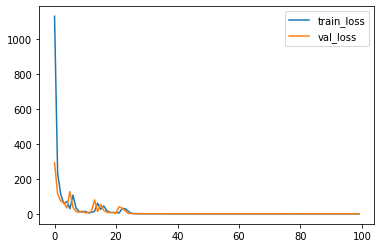

In [32]:
# Plot1
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()

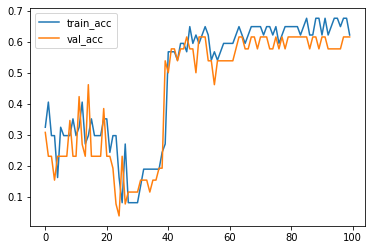

In [33]:
# Plot2
plt.plot(hist.history['accuracy'], label='train_acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
plt.legend()

## Trying Random Forest

In [34]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [35]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8076923076923077


In [36]:
cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred))

In [37]:
cm.head()

,0,1,2,3
0,6,0,0,0
1,0,4,0,2
2,0,3,0,0
3,0,0,0,11


In [38]:
labels = ['Low', 'Low_Middle', 'High_Middle','High']

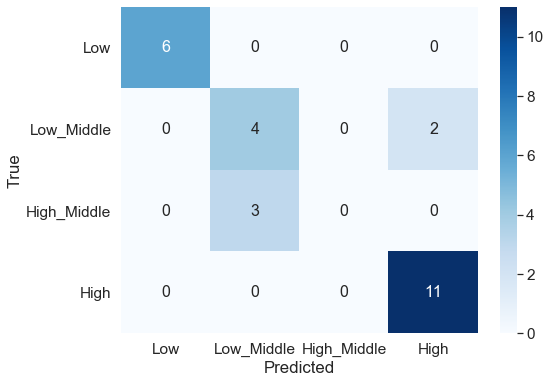

In [39]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, cmap="Blues", annot_kws={"size": 16},
           xticklabels=labels, yticklabels= labels) # font size

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [40]:
importances = clf.feature_importances_

In [41]:
cols = X.columns

In [42]:
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


Feature ranking:
1. feature 2 (0.322464) GDP per capita (constant 2010 US$)
2. feature 6 (0.167071) Rural population (% of total population)
3. feature 3 (0.156094) Life expectancy at birth, total (years)
4. feature 0 (0.129045) Arable land (hectares per person)
5. feature 1 (0.100075) Food production index (2004-2006 = 100)
6. feature 5 (0.068974) Adjusted savings: education expenditure (% of GNI)
7. feature 4 (0.056276) Population density (people per sq. km of land area)


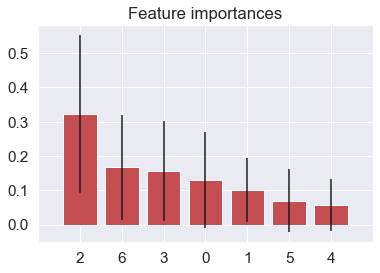

In [43]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]), cols[indices[f]])

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()